In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm
import numpy as np
from statsmodels.tsa.stattools import adfuller

n_periodos_a_predecir = 5

df = pd.read_csv('71ecc197-6e49-4120-8b66-1e7a69d259a3.csv')
df['año'] = pd.to_datetime(df['año'].astype(str))
df = df.groupby(['año', 'municipio']).agg(totalgeneral_sum=('total general', 'sum')).reset_index()
loc_0 = df.columns.get_loc('municipio')
df_split = df['municipio'].str.split(pat='^\\d+\\s+', expand=True).add_prefix('municipio_')
df = pd.concat([df.iloc[:, :loc_0], df_split, df.iloc[:, loc_0:]], axis=1)
df = df.drop(columns=['municipio', 'municipio_0'])
df = df.rename(columns={'municipio_1': 'municipio', 'totalgeneral_sum' : 'nacimientos'})
df['municipio'] = df['municipio'].str.lower()
municipios = df['municipio'].unique()
df = df.groupby(['municipio', 'año'])['nacimientos'].sum().reset_index()
df_resultados = pd.DataFrame()

In [21]:
df

,municipio,año,nacimientos
0,abejorral,2008-01-01,162
1,abejorral,2009-01-01,163
2,abejorral,2010-01-01,150
3,abejorral,2011-01-01,134
4,abejorral,2012-01-01,132
...,...,...,...
16577,útica,2019-01-01,1
16578,útica,2020-01-01,0
16579,útica,2021-01-01,0
16580,útica,2022-01-01,0


In [25]:
df[df['año']=='2020']['nacimientos'].sum()

629402

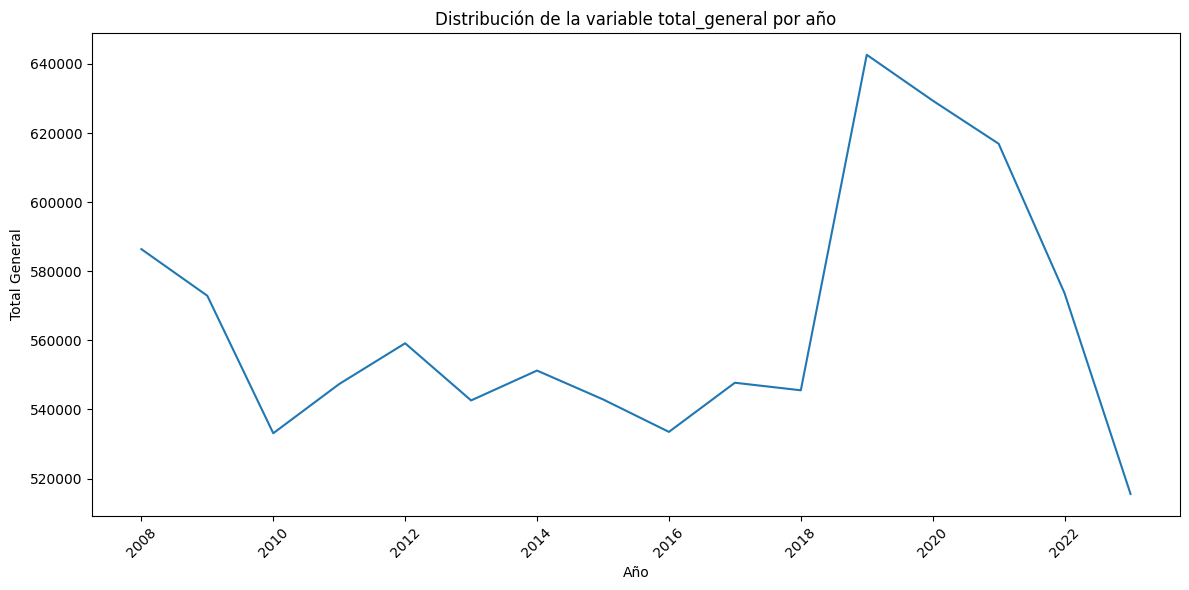

In [20]:
import seaborn as sns
df_plot = df.copy()
df_plot['año'] = pd.to_datetime(df_plot['año'].astype(str)).dt.year
df_plot = df_plot.groupby(['año']).agg(totalgeneral_sum=('nacimientos', 'sum')).reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(x='año', y='totalgeneral_sum', data=df_plot)
plt.title('Distribución de la variable total_general por año')
plt.xlabel('Año')
plt.ylabel('Total General')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [33]:
adf_test = adfuller(df["nacimientos"])
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

ADF Statistic: -17.770425
p-value: 0.000000


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
ultimo_anio_conocido = df['año'].dt.year
ultimo_anio_conocido = ultimo_anio_conocido.max()
anios_futuros = np.arange(ultimo_anio_conocido + 1, ultimo_anio_conocido + 1 + n_periodos_a_predecir).reshape(-1, 1)
for municipio in municipios:
    df_municipio = df[df['municipio'] == municipio].copy()
    df_municipio["año_num"] = df_municipio['año'].dt.year
    X_hist = df_municipio[['año_num']]
    if len(X_hist) > 2:
        y_hist = df_municipio['nacimientos']
        model = LinearRegression()
        model.fit(X_hist, y_hist)
        if df_municipio['año_num'].max() == ultimo_anio_conocido:
            predicciones_futuras = model.predict(anios_futuros)
            # Imprimir las predicciones
            for anio, pred in zip(anios_futuros.flatten(), predicciones_futuras):
                df_resultados = pd.concat([df_resultados, pd.DataFrame({'municipio': [municipio], 'año': [anio], 'nacimientos': [int(pred)]})], ignore_index=True)


c:\Users\USUARIO\OneDrive\Documentos\Education\Maestria_UNIR_BigData\TFM\Desarrollo\.venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\USUARIO\OneDrive\Documentos\Education\Maestria_UNIR_BigData\TFM\Desarrollo\.venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\USUARIO\OneDrive\Documentos\Education\Maestria_UNIR_BigData\TFM\Desarrollo\.venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\USUARIO\OneDrive\Documentos\Education\Maestria_UNIR_BigData\TFM\Desarrollo\.venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fit

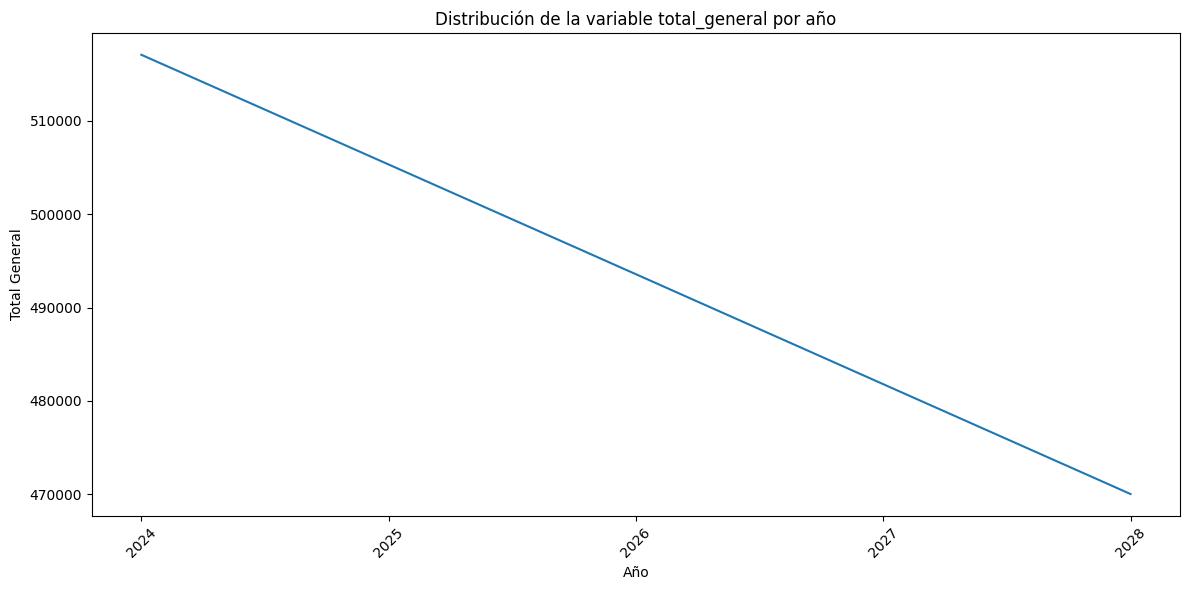

In [29]:
import seaborn as sns
df_plot_pred = df_resultados.groupby(['año']).agg(totalgeneral_sum=('nacimientos', 'sum')).reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(x='año', y='totalgeneral_sum', data=df_plot_pred)
plt.title('Distribución de la variable total_general por año')
plt.xlabel('Año')
plt.ylabel('Total General')
plt.xticks(ticks=anios_futuros.flatten())
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [74]:
df_resultados

,municipio,año,nacimientos
0,medellín,2024,35794
1,medellín,2025,35392
2,medellín,2026,34991
3,medellín,2027,34589
4,medellín,2028,34187
...,...,...,...
5030,angelópolis,2024,3
5031,angelópolis,2025,3
5032,angelópolis,2026,4
5033,angelópolis,2027,4


In [30]:
df_plot_med = df_resultados[df_resultados['municipio'] == 'medellín']
df_med = df[df['municipio']=="medellín"]
df_med['año'] = df_med['año'].dt.year
df_med['año'] = df_med['año'].astype(int)
df_plot_med = pd.concat([df_plot_med, df_med])


C:\Users\USUARIO\AppData\Local\Temp\ipykernel_16836\911072107.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_med['año'] = df_med['año'].dt.year
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_16836\911072107.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_med['año'] = df_med['año'].astype(int)


In [87]:
df_plot_med

,municipio,año,nacimientos
0,medellín,2024,35794
1,medellín,2025,35392
2,medellín,2026,34991
3,medellín,2027,34589
4,medellín,2028,34187
0,medellín,2008,43155
1122,medellín,2009,41734
2244,medellín,2010,38825
3366,medellín,2011,38480
4489,medellín,2012,39512


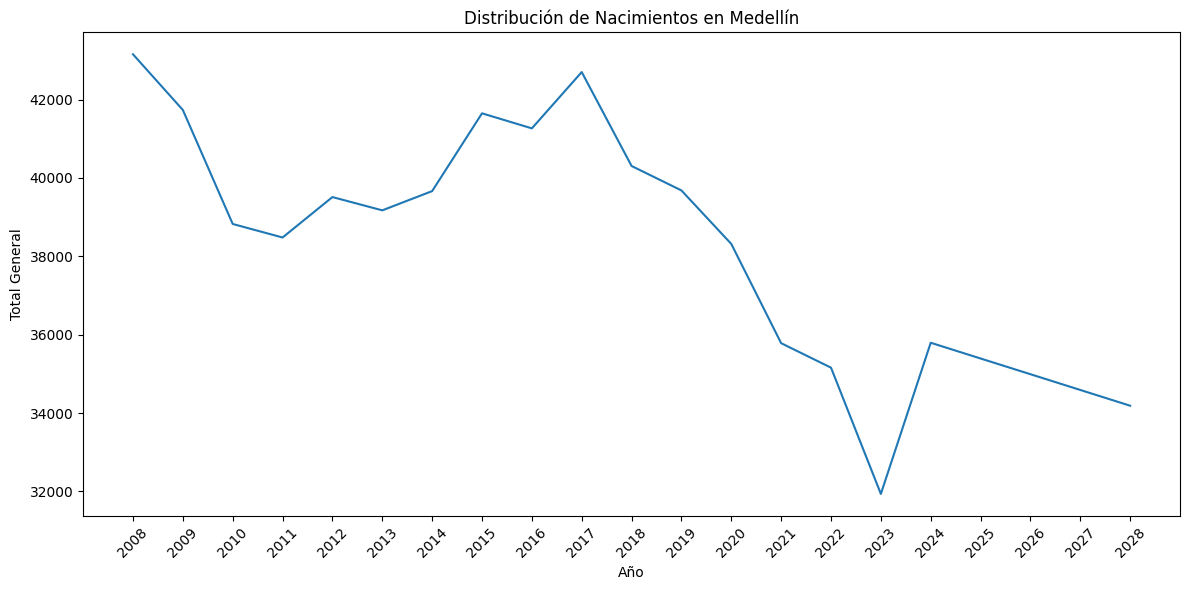

In [31]:

plt.figure(figsize=(12, 6))
sns.lineplot(x='año', y='nacimientos', data=df_plot_med)
plt.title('Distribución de Nacimientos en Medellín')
plt.xlabel('Año')
plt.ylabel('Total General')
plt.xticks(ticks=df_plot_med['año'].unique().flatten())
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
lista_de_resultados = []
df_real = pd.DataFrame()
ultimo_anio_conocido = df['año'].max()
for municipio in municipios:
    df_municipio = df[df['municipio'] == municipio].copy()
    if df_municipio['año'].max() == ultimo_anio_conocido:
        if len(df_municipio) < 10: # Umbral mínimo de puntos de datos
            print(f"Datos insuficientes para {municipio}. Se omite el modelo.")
            continue # Salta a la siguiente iteración del bucle
        print(df_municipio)
        df_municipio = df_municipio.set_index('año')
        df_municipio.index.freq = 'YS'
        y = df_municipio['nacimientos']
        X = pd.DataFrame(index=y.index)
        X['Pandemia'] = 0
        X.loc['2020-01-01':'2022-01-01', 'Pandemia'] = 1
        print(f"--- Entrenando modelo ARIMAX para el Municipio: {municipio} ---")
        arimax_model = pm.auto_arima(y, X=X,
                                    seasonal=False,
                                    trace=True, # Muestra el proceso de búsqueda
                                    error_action='ignore',
                                    suppress_warnings=True)
        # Para el futuro, la variable 'Pandemia' vuelve a ser 0
        X_futuro = pd.DataFrame({
            'Pandemia': [0] * n_periodos_a_predecir
        }, index=pd.date_range(start=ultimo_anio_conocido, periods=n_periodos_a_predecir+1, freq='YS')[1:])
        prediccion, conf_int = arimax_model.predict(n_periods=n_periodos_a_predecir, X=X_futuro, return_conf_int=True)
        print("\n--- PREDICCIÓN MODELO {municipio}---")
        print(prediccion)

        df_real = pd.DataFrame({
            'municipio': municipio,
            'año': y.index,
            'tipo': 'Real',
            'nacimientos': y.values,
            'intervalo_inferior': np.nan, # No aplica para datos reales
            'intervalo_superior': np.nan, # No aplica para datos reales
            'modelo_arima': str(arimax_model.order)
        })
        df_pred = pd.DataFrame({
            'municipio': municipio,
            'año': prediccion.index,
            'tipo': 'Predicción',
            'nacimientos': prediccion.values,
            'intervalo_inferior': conf_int[:, 0],
            'intervalo_superior': conf_int[:, 1],
            'modelo_arima': str(arimax_model.order)
        })

        df_completo_municipio = pd.concat([df_real, df_pred], ignore_index=True)
        
        lista_de_resultados.append(df_completo_municipio)

df_final_arima = pd.concat(lista_de_resultados, ignore_index=True)


In [4]:
df_final_arima.to_csv('resultados_arima.csv', index=False)

Analisis de Resultados

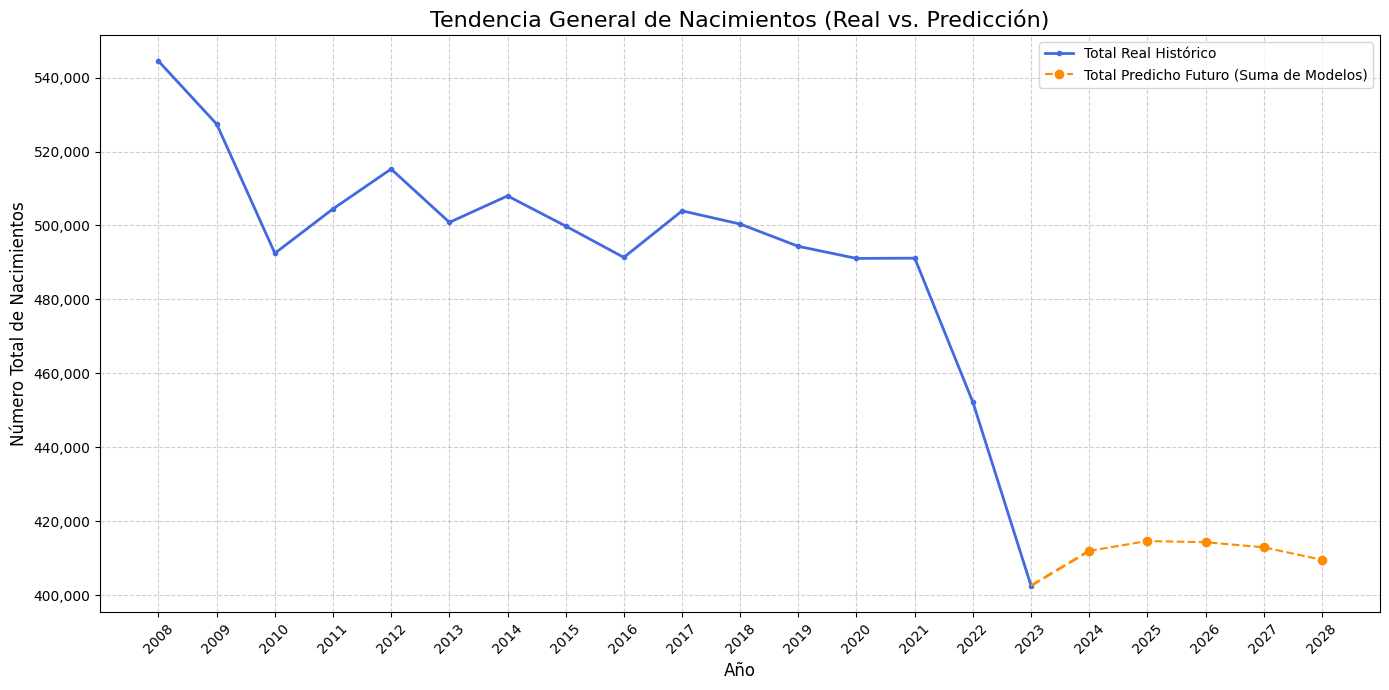

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

df_total_general = df_final_arima.groupby(['año', 'tipo'])['nacimientos'].sum().reset_index()

df_total_real = df_total_general[df_total_general['tipo'] == 'Real']
df_total_pred = df_total_general[df_total_general['tipo'] == 'Predicción']

ultimo_punto_real = df_total_real.iloc[[-1]] 
primer_punto_pred = df_total_pred.iloc[[0]]
df_conexion = pd.concat([ultimo_punto_real, primer_punto_pred], ignore_index=True)

plt.figure(figsize=(14, 7))

plt.plot(df_total_real['año'], df_total_real['nacimientos'], 
         label='Total Real Histórico', color='royalblue', linewidth=2, marker='.')

plt.plot(df_conexion['año'], df_conexion['nacimientos'], 
         color='darkorange', linestyle='--', linewidth=2)

plt.plot(df_total_pred['año'], df_total_pred['nacimientos'], 
         label='Total Predicho Futuro (Suma de Modelos)', color='darkorange', linestyle='--', marker='o')
todos_los_anios = pd.concat([df_total_real['año'], df_total_pred['año']]).unique()
etiquetas_de_anio = [d.year for d in todos_los_anios]
plt.xticks(ticks=todos_los_anios, labels=etiquetas_de_anio, rotation=45)


# 6. Añadir títulos y etiquetas para claridad
plt.title('Tendencia General de Nacimientos (Real vs. Predicción)', fontsize=16)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Número Total de Nacimientos', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Formatear el eje Y
ax = plt.gca()
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.tight_layout()
plt.show()
